In [1]:
import requests as req
from bs4 import BeautifulSoup
import json
import re
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os

def dms_to_decimal(dms):
    deg, minutes, seconds, direction =  re.split('[^A-Za-z0-9]', dms)
    decimal_degrees = float(deg) + float(minutes)/60 + float(seconds)/(60*60)
    if direction in ['W', 'S']:
        decimal_degrees *= -1
    return decimal_degrees

def get_station_list():
    index_url = "https://en.wikipedia.org/wiki/List_of_MTR_stations"
    response = req.get(index_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    a_list = soup.select("#mw-content-text > div.mw-parser-output > table > tbody > tr > td:nth-child(2) > a")
    station_list = [a.attrs for a in a_list]
    return station_list

def find_station_longlat(url):
    response = req.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    lat = soup.select_one("span.latitude").text
    long = soup.select_one("span.longitude").text
    return {"lat": lat, "long": long}

def get_stations_info():
    station_list = get_station_list()
    for station in station_list:
        url = f"https://en.wikipedia.org{station['href']}"
        print("get:",url)
        latlong = find_station_longlat(url)
        station.update(latlong)
    return station_list

def preprocess(station_list):
    for station in station_list:
        try:
            station["lat"] = dms_to_decimal(station["lat"])
            station["long"] = dms_to_decimal(station["long"])
        except:
            pass
        station["title"] = station["title"].replace("(MTR)", "").replace("station", "").strip()
    return station_list

In [7]:
if not os.path.exists("data/MTRStations.json"):
    stations_info = get_stations_info()
    with open("data/MTRStations.json", "w") as f:
        json.dump(stations_info, f)
else:
    with open("data/MTRStations.json", "r") as f:
        stations_info = json.load(f)

In [72]:
stations_info = preprocess(stations_info)
mtr = pd.DataFrame(stations_info)
mtr = gpd.GeoDataFrame({'name':mtr['title']}, geometry=gpd.points_from_xy(mtr.long, mtr.lat)).drop_duplicates()
mtr.set_crs(epsg=4326,inplace=True)
mtr

,name,geometry
0,Admiralty,POINT (114.16472 22.27889)
1,Exhibition Centre,POINT (114.17528 22.28167)
2,Hung Hom,POINT (114.18167 22.30278)
3,Mong Kok East,POINT (114.17278 22.32222)
4,Kowloon Tong,POINT (114.17611 22.33694)
...,...,...
114,Disneyland Resort,POINT (114.04500 22.31556)
116,South Horizons,POINT (114.14917 22.24250)
117,Lei Tung,POINT (114.15611 22.24222)
118,Wong Chuk Hang,POINT (114.16806 22.24806)


In [9]:
data_path = "data/DCCA_21C.geojson"
dcca = gpd.read_file(data_path).to_crs(epsg=4326)

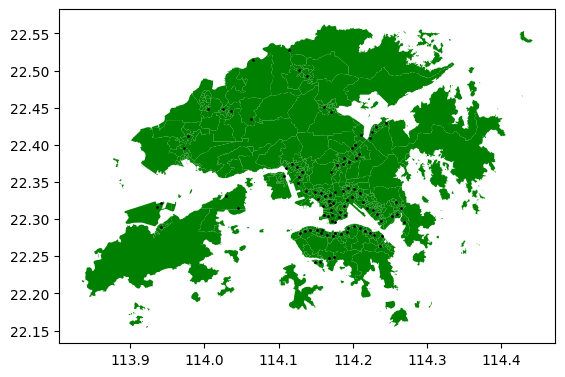

In [10]:
fig,ax = plt.subplots()
dcca.plot(ax=ax,color='green')
mtr.plot(ax=ax,color='black',markersize=1)
plt.show()

In [49]:
yoshi_url = "https://www.yoshinoya.com.hk/wp-admin/admin-ajax.php?lang=en&action=store_search&lat=22.396428&lng=114.109497&max_results=100&search_radius=500&autoload=1"
response = req.get(yoshi_url)
yoshi = pd.DataFrame(json.loads(response.content))[['store','lng','lat']].replace('',np.nan).dropna()
yoshi = gpd.GeoDataFrame(yoshi['store'], geometry=gpd.points_from_xy(yoshi.lng, yoshi.lat))
yoshi.set_crs(epsg=4326,inplace=True)
yoshi = yoshi.to_crs(epsg=2326)
yoshi['region'] = yoshi.buffer(500).to_crs(epsg=4326)
yoshi = yoshi.to_crs(epsg=4326)

In [73]:
yoshi_with_mtr = yoshi.loc[yoshi.apply(lambda store: mtr.geometry.within(store.region).any(), axis=1)]
mtr_with_yoshi = mtr.loc[mtr.apply(lambda station: yoshi.region.contains(station.geometry).any(), axis=1)]

In [77]:
yoshi_with_mtr["distan"] = yoshi_with_mtr.to_crs(epsg=2326).apply(lambda store: mtr_with_yoshi.to_crs(epsg=2326).geometry.distance(store.geometry).min(), axis=1)

/Users/creator/Library/Python/3.9/lib/python/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


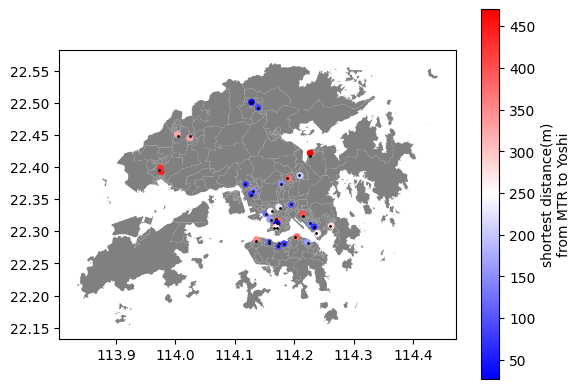

In [92]:
fig,ax = plt.subplots()
dcca.plot(ax=ax,color="grey")
# yoshi_with_mtr.region.plot(ax=ax,color='red')
yoshi_with_mtr.plot("distan", ax=ax, markersize=15, legend=True, cmap="bwr",legend_kwds={'label': "shortest distance(m)\nfrom MTR to Yoshi"})
mtr_with_yoshi.plot(ax=ax,color='black',markersize=1)
plt.show()